# KPP test stand efficiency analysis 

In [2]:
# External libraries
import sys
import awkward as ak

# Mu2e pyutils
sys.path.append("../EventNtuple/utils/pyutils")

import pyprint 
import pyplot 

pr = pyprint.Print()
pl = pyplot.Plot()

# anapytools
from anapytools.read_data import DataReader
reader = DataReader()

# EffAna methods
sys.path.append("../Utils")
from processor import Processor # Process rec trees into ak
from clean import Clean # Filter data
from crvaging019 import CrvAging019 # Get PEs/layer for crvaging-019
from cuts import Cuts # Apply cuts
from trigger import Trigger # Trigger
from sort import Sort # Sort PEs / layer
from histogrammer import Histogrammer # Accumulate histograms 
from scan_inefficiency import ScanInefficiency # Scan inefficiency

## Process data

In [11]:
# Initialise
reader = DataReader()
processor = Processor(reader=reader)

# Configure dataset
defname = "rec.mu2e.CRV_wideband_cosmics.CRVWB-000-010-000.root"
run_number="002101"

# Get filelist
filelist = processor.get_filelist(defname, run_number)

# Process files
arrays = processor.process_files_parallel(filelist)

# Print array info
arrays.type.show()
print("\n → FEBs:", len(arrays['PEsTemperatureCorrected'][0,:,0]))
print(" → Channels / FEB:", len(arrays['PEsTemperatureCorrected'][0,0,:]))

---> Loading Processor...
filelist: ['rec.mu2e.CRV_wideband_cosmics.CRVWB-000-010-000.002101_000.root', 'rec.mu2e.CRV_wideband_cosmics.CRVWB-000-010-000.002101_001.root', 'rec.mu2e.CRV_wideband_cosmics.CRVWB-000-010-000.002101_002.root', 'rec.mu2e.CRV_wideband_cosmics.CRVWB-000-010-000.002101_003.root', 'rec.mu2e.CRV_wideband_cosmics.CRVWB-000-010-000.002101_004.root']

---> Starting parallel processing with 5 workers...
Processing 5 files in total

✓ rec.mu2e.CRV_wideband_cosmics.CRVWB-000-010-000.002101_003.root processed successfully!
  → Events in this file: 154878
  → Progress: 1/5 files (20.0%)

✓ rec.mu2e.CRV_wideband_cosmics.CRVWB-000-010-000.002101_002.root processed successfully!
  → Events in this file: 149914
  → Progress: 2/5 files (40.0%)

✓ rec.mu2e.CRV_wideband_cosmics.CRVWB-000-010-000.002101_001.root processed successfully!
  → Events in this file: 156933
  → Progress: 3/5 files (60.0%)

✓ rec.mu2e.CRV_wideband_cosmics.CRVWB-000-010-000.002101_004.root processed succe

## Clean data 

In [13]:
# I tihnk this is needed... I think these are corrupt events 
# clean = Clean(arrays)
# arrays = clean.remove_negative_PEs()

# class Clean:
#     def __init__(self, arrays):
#         """Initialise"""
#         print("---> Loading Clean...")
#         self.arrays = arrays
            
#     def remove_negative_PEs(self): 
#         """Remove events containing negative PE values
#         Args:
#             arrays: awkward array containing PE measurements 
#         Returns:
#             arrays: filtered array with only events containing non-negative PE values
#         """
        
#         has_negatives = ak.any(self.arrays["PEsTemperatureCorrected"] < 0, axis=-1)
#         # Reset to event level 
#         has_negatives_in_event = ak.any(has_negatives, axis=-1, keepdims=False) == True 
#         # Count events
#         n_events_negative = ak.sum(ak.values_astype(has_negatives, "int"))
        
#         print(f"Removing {n_events_negative}/{len(self.arrays)} events containing negative PE values")
        
#         # Remove events with negative PEs
#         return self.arrays[~has_negatives_in_event]

# arrays_test = ak.copy(arrays)
# clean = Clean(arrays_test)
# arrays_test = clean.remove_negative_PEs()
# arrays_test["PEsTemperatureCorrected"].type.show()

clean = Clean(arrays)
arrays = clean.remove_negative_PEs()
# Check structure 
arrays["PEsTemperatureCorrected"].type.show()


---> Loading Clean...
Removing 3873/773205 events containing negative PE values
769332 * 8 * 64 * float32
---> Loading Clean...
Removing 3873/773205 events containing negative PE values
769332 * 8 * 64 * float32


## Get PEs/layer

In [14]:
crvaging019 = CrvAging019(arrays)
arrays = crvaging019.crv_L_end()
arrays = crvaging019.crv_T()
arrays = crvaging019.crv_DS()
print()
arrays.type.show()
pr.PrintNEvents(arrays, 1)

---> Loading CrvAging019...

---> Mapping CRV-L-end
Layer 0 matches ✓
Layer 1 matches ✓
Layer 2 matches ✓
Layer 3 matches ✓

---> Mapping CRV-T
Layer 0 matches ✓
Layer 1 matches ✓
Layer 2 matches ✓
Layer 3 matches ✓

---> Mapping CRV-DS
Layer 0 matches ✓
Layer 1 matches ✓
Layer 2 matches ✓
Layer 3 matches ✓

769332 * {
    eventNumber: int32,
    PEsTemperatureCorrected: 8 * 64 * float32,
    subrun: int64,
    PEs_per_layer_L_end: 4 * 32 * float32,
    PEs_per_layer_T: 4 * 32 * float32,
    PEs_per_layer_DS: 4 * 32 * float32
}

---> Printing 1 event(s)...

-------------------------------------------------------------------------------------
eventNumber: 1
PEsTemperatureCorrected: [[0, 0, 0, 0, 0, 0, 0, 1.25, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], ...]
subrun: 3
PEs_per_layer_L_end: [[0, 0, 0.617, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], ...]
PEs_per_layer_T: [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0.866, 0, 0, 0, 0, 0, 0, 0], ...]
PEs_per_layer_DS: [[0, 

## Apply physics cuts


---> Loading Cuts...
Initial number of events: 769332


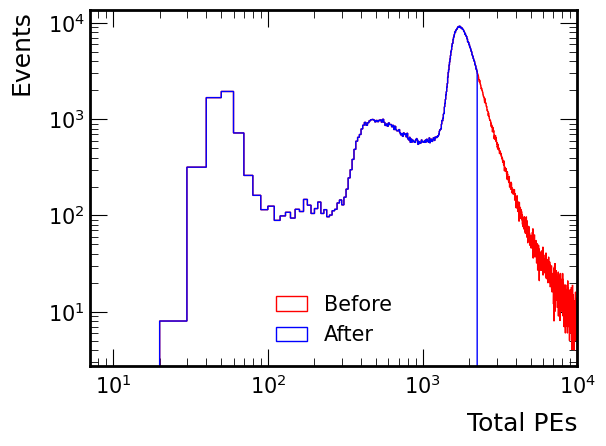


Total PE cut (< 2250):
Events removed: 163925 (21.3%)
Events remaining: 605407 (78.7% of initial)


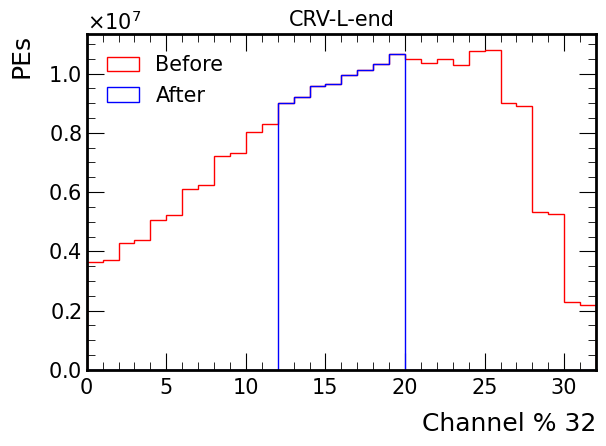


Fiducial cut (channels 12-19):


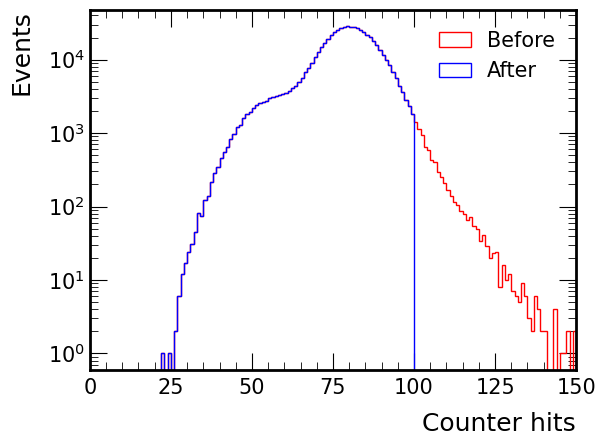


Counters hit cut (≤ 100):
Events removed: 7526 (1.2%)
Events remaining: 597881 (77.7% of initial)


In [16]:
cuts = Cuts(arrays, verbose=True)

max_PEs = 2250
# 0,1,2,3 4,5,6,7 8,9,10,11 12,13,14,15 16,17,18,19 20,21,22,23 24,25,26,27, 28,29,30,31
lo_chan=12
hi_chan=19
min_counter_hits=8*2
max_counter_hits=100

# Make a copy
arrays_cut = ak.copy(arrays)

arrays_cut = cuts.tot_PE_cut(max_PEs=max_PEs)
arrays_cut = cuts.fiducial_cut(lo_chan=lo_chan, hi_chan=hi_chan) 
arrays_cut = cuts.counters_hit_cut(min_counter_hits=min_counter_hits, max_counter_hits=max_counter_hits)

## Trigger

In [17]:
# Initiliase
trigger = Trigger(arrays_cut)
# Find triggers
arrays_cut = trigger.get_triggers()
# Apply triggers
arrays_cut = trigger.apply_triggers()

---> Loading Trigger...
---> Triggering
-> 69728/597881 = 11.66% events have triggers


## Sort PEs in test module

In [18]:
sort = Sort()
arrays_cut["PEs_per_layer_T_sorted"] = sort.sort_layer_PEs(arrays_cut['PEs_per_layer_T'])
sort.print_sorted_layer_PEs(arrays_cut['PEs_per_layer_T_sorted'])

---> Loading Sort...
Sorted PEs:
0 [79.9, 95.6, 104, 127]
1 [84.9, 104, 105, 106]
2 [79, 81.9, 95.1, 96.4]
3 [74, 91.3, 132, 161]
4 [94.1, 122, 135, 264]
5 [106, 119, 127, 144]
6 [91.2, 139, 179, 218]
7 [95.1, 122, 132, 187]
8 [74.7, 84.5, 96.5, 129]
9 [92.5, 101, 152, 174]
...


x_max = 465.8336181640625
---> Loading Hists...


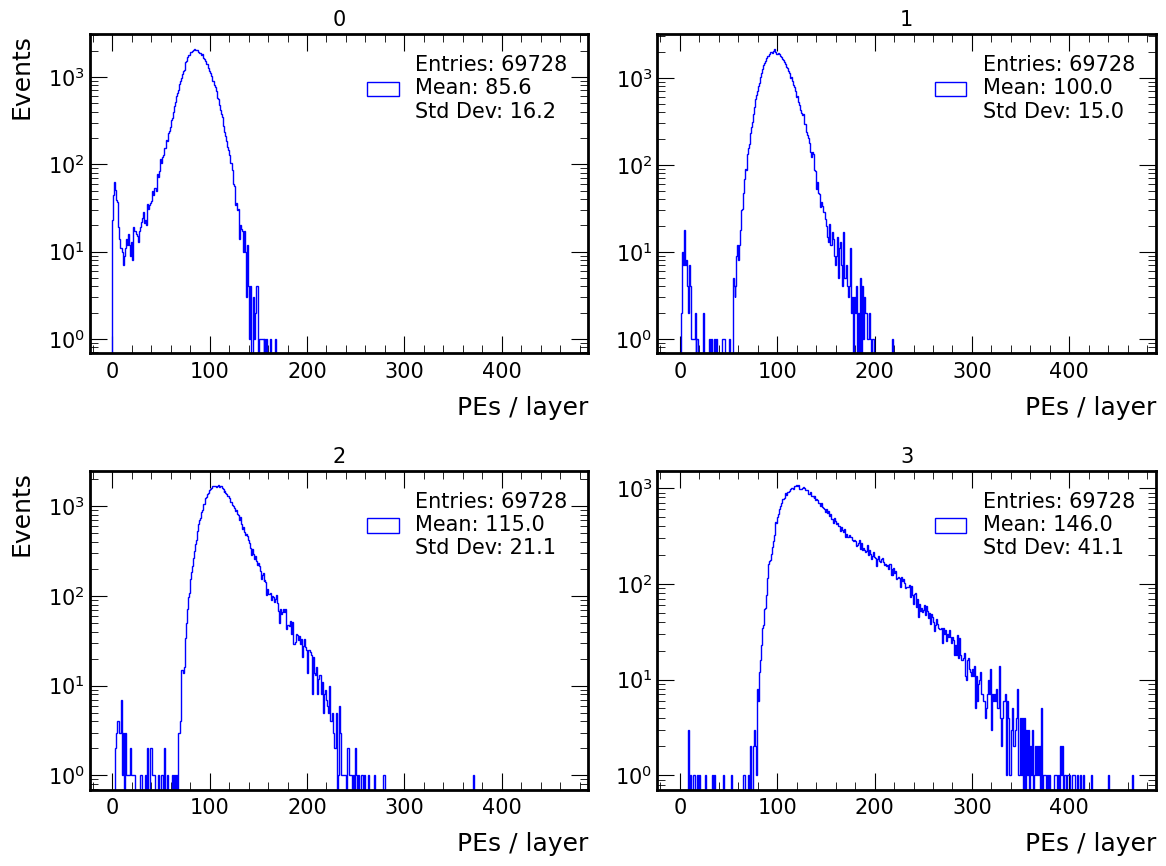

In [19]:
x_max = max(ak.flatten(arrays_cut['PEs_per_layer_T_sorted'][:,3], axis=None))
print(f"x_max = {x_max}")
histogrammer = Histogrammer(nbins=int(x_max), x_range=(0, x_max)) 
hists = histogrammer.acc_hists(arrays_cut)
histogrammer.plot_hists(hists)

## Scan inefficiency 

---> Loading Inefficiency...
PE thresholds to scan:
[ 10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.  70.  75.
  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135. 140. 145.
 150.]


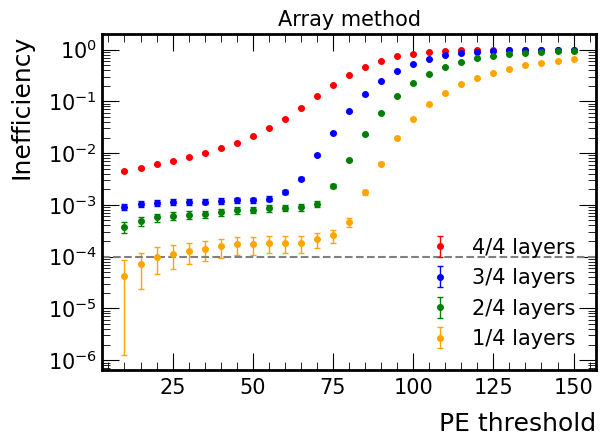

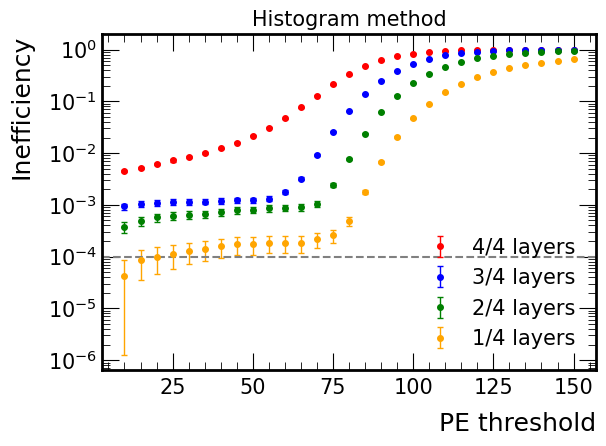

In [20]:
inefficiency = ScanInefficiency()

# Array method
thresholds, ineff, ineff_err = inefficiency.scan_ineff_arrays(arrays_cut)
inefficiency.plot_scan(ineff, ineff_err, title="Array method")

# print("threshold, ineff")
# for i_thres, threshold in enumerate(thresholds):
#     print(f"{threshold}, {ineff[1][i_thres]}") 

# Histogram method
thresholds, ineff, ineff_err = inefficiency.scan_ineff_hists(hists)
inefficiency.plot_scan(ineff, ineff_err, title="Histogram method")

# print("threshold, ineff")
# for i_thres, threshold in enumerate(thresholds):
#     print(f"{threshold}, {ineff[1][i_thres]}") 
    

## Debugging

In [10]:
# import numpy as np
# import awkward as ak
# import matplotlib.pyplot as plt
# from statsmodels.stats.proportion import proportion_confint

# class ScanInefficiencyDebug:
#     def __init__(self, start=10, stop=150, steps=29, verbose=True):
#         """Initialise inefficiency scanner 
#         Args:
#             start (int): starting threshold
#             stop (int): ending threshold
#             steps (int): number of scan points
#             verbose (bool): printouts 
#         """
#         print("---> Loading Inefficiency...")
#         # Validate inputs
#         if stop <= start:
#             raise ValueError("'stop' must be greater than 'start'")
#         if steps < 2:
#             raise ValueError("'steps' must be >= 2")
#         self.start = start
#         self.stop = stop
#         self.steps = steps
#         self.n_layers = 4 # Number of layers/module
#         # Create scan points
#         self.thresholds = np.linspace(self.start, self.stop, self.steps)
#         if verbose: 
#             print(f"PE thresholds to scan:\n{self.thresholds}")        

#     def get_ineff(self, k, N):
#         """Calculate inefficiency
        
#         Args:
#             k (int): Number of failures
#             N (int): Total number of triggers
        
#         Returns:
#             float: inefficiency (float)
#         """
#         return k / N if N > 0 else 0

#     def get_ineff_err(self, k, N, conservative=True):
#         """Calculate Wilson confidence interval for proportion
        
#         Args:
#             k (int): Number of failures
#             N (int): Total number of trials
#             conservative (bool): If True, use upper bound difference
        
#         Returns:
#             float: Uncertainty estimate
            
#         Raises:
#             ValueError: If k > N or if either is negative
#         """
#         if k > N or k < 0 or N < 0:
#             raise ValueError("Invalid k or N values")
            
#         lower, upper = proportion_confint(k, N, method="wilson")
#         point = k/N
        
#         if conservative:
#             return abs((upper - point) / 2)
#         else:
#             return abs((lower - point) / 2)

#     def _create_result_arrays(self):
#         """Create fresh arrays for storing results"""
#         ineff = {i: np.zeros(self.steps) for i in range(self.n_layers)}
#         ineff_err = {i: np.zeros(self.steps) for i in range(self.n_layers)}
#         return ineff, ineff_err
        
#     def scan_ineff_arrays(self, arrays):
#         """Scan array to calculate inefficiency at different PE thresholds
        
#         Args:
#             arrays: awkward array containing triggered and sorted PEs in test module
            
#         Returns:
#             tuple: (x, y, yerr)
#                 x: PE threshold values as list
#                 y: Inefficiency values as dict (keys are sorted layer indices)
#                 yerr: Inefficiency uncertainty as dict (keys are sorted layer indices)
#         """
#         # Get result arrays
#         ineff, ineff_err = self._create_result_arrays()
#         # Total triggers
#         N = len(arrays)

#         print(f"*** Array method total events: {N}")
        
#         # For each scan point
#         for i_thres, thres in enumerate(self.thresholds):
#             # Mark failures 
#             arrays[f"fail_{thres}"] = ak.values_astype(
#                 ( (arrays["PEs_per_layer_T_sorted"] <= thres) 
#                  & (arrays["PEs_per_layer_T_sorted"] >= 0) # Sometimes there are -32 values in the array!
#                 ), "int"
#             ) 
#             # For i/4 layers
#             for i_layer in range(self.n_layers):
#                 # Get failures 
#                 k = ak.sum(arrays[f"fail_{thres}"][:,i_layer])
#                 if thres == 10:
#                     print(f"*** Array failures at {thres}: {k}")
#                 # Get and store inefficiency
#                 ineff[i_layer][i_thres] = self.get_ineff(k, N)
#                 # Get and store uncertainty on inefficiency
#                 ineff_err[i_layer][i_thres] = self.get_ineff_err(k, N)
#         return self.thresholds, ineff, ineff_err 

#     def scan_ineff_hists(self, hists):
#         """Scan histogram to calculate inefficiency at different PE thresholds
        
#         Args:
#             hists (dict): Sorted PE/layer histograms
            
#         Returns:
#             tuple: (x, y, yerr)
#                 x: PE threshold values as list
#                 y: Inefficiency values as dict (keys are sorted layer indices)
#                 yerr: Inefficiency uncertainty as dict (keys are sorted layer indices)
#         """
#         # Get result arrays
#         ineff, ineff_err = self._create_result_arrays()

#         for i_layer in range(self.n_layers):
        
#             counts = hists[i_layer]['counts']
#             bin_edges = hists[i_layer]['bin_edges']
#             N = np.sum(counts)
            
#             print(f"*** Bin edges near 10: {bin_edges[bin_edges.searchsorted(10)-2:bin_edges.searchsorted(10)+2]}")
#             print(f"*** Hist method total events (layer {i_layer}): {N}")
#             # For each scan point
#             for i_thres, thres in enumerate(self.thresholds):
#                 # Find bins below threshold
#                 mask = bin_edges[:-1] <= thres # Use left bin edge
#                 k = np.sum(counts[mask])
#                 if thres == 10:
#                     print(f"*** Hist failures at {thres}: {k}")
#                 # Calculate inefficiency
#                 ineff[i_layer][i_thres] = k / N if N > 0 else 0
#                 # Calculate uncertainty using instance method
#                 ineff_err[i_layer][i_thres] = self.get_ineff_err(k, N)
    
#         return self.thresholds, ineff, ineff_err 

#     def plot_scan(self, ineff, ineff_err, title=None, fout=None):
#         """  
#           Plot inefficiency scan 
#         """  
#         # Create figure and axes
#         fig, ax = plt.subplots()

#         # Loop through graphs and plot
#         for i_layer in range(self.n_layers): 
#             # Create this graph
#             ax.errorbar(
#               x=self.thresholds, y=ineff[i_layer], yerr=ineff_err[i_layer], label=f"{self.n_layers-i_layer}/4 layers",
#               fmt='o', markersize=4, capsize=2, elinewidth=1
#             )
#         # Set log-y scale
#         ax.set_yscale("log")

#         # Titles
#         ax.set_title(title)
#         ax.set_ylabel("Inefficiency")
#         ax.set_xlabel("PE threshold")

#         # Legend
#         ax.legend(loc="best")

#         # Draw inefficiency line
#         ax.axhline(y=1e-4, color='gray', linestyle='--')
#         ax.text(90, 0.33e-4, "99.99% efficiency", color="gray", fontsize="small") 

#         # Draw
#         plt.tight_layout()
    
#         # Save 
#         if fout:
#           plt.savefig(fout, dpi=300, bbox_inches="tight")
#           print("\n---> Wrote:\n\t", fout)
            
#         # Show
#         plt.show()

In [11]:
# arrays_debug = ak.copy(arrays_cut)

# # I think this part works OK 
# for thres in thresholds:
#     # Mark failures 
#     arrays_debug[f"fail_{thres}"] = ak.values_astype((arrays_debug["PEs_per_layer_T_sorted"] < thres), "int") 

# # pr.PrintNEvents(arrays_debug)

# # k = ak.sum(arrays[f"fail_{thres}"][:,i_layer], axis=None)

# print(arrays_debug[f"fail_150.0"][:,1])
# print(len(arrays_debug))
# print(ak.sum(arrays_debug[f"fail_150.0"][:,1]))

In [12]:
# inefficiency = ScanInefficiencyDebug()

# # Array method
# thresholds, ineff, ineff_err = inefficiency.scan_ineff_arrays(arrays_debug)
# inefficiency.plot_scan(ineff, ineff_err, title="Array method")

# print("threshold, ineff")
# for i_thres, threshold in enumerate(thresholds):
#     print(f"{threshold}, {ineff[1][i_thres]}") 

# # Histogram method
# thresholds, ineff, ineff_err = inefficiency.scan_ineff_hists(hists)
# inefficiency.plot_scan(ineff, ineff_err, title="Histogram method")

# print("threshold, ineff")
# for i_thres, threshold in enumerate(thresholds):
#     print(f"{threshold}, {ineff[1][i_thres]}") 

# failure_mask = arrays_debug[f"fail_50.0"][:,1] == 1
# failure_PEs = arrays_debug["PEs_per_layer_T_sorted"][:,1][failure_mask]
# print(f"PE values counted as failures: {ak.to_numpy(failure_PEs)[:10]}")

# print(arrays_debug["PEs_per_layer_T_sorted"][:,1][arrays_debug["PEs_per_layer_T_sorted"][:,1] < 0])
# print(len(arrays_debug["PEs_per_layer_T_sorted"][:,1][arrays_debug["PEs_per_layer_T_sorted"][:,1] < 0]))